In [1]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Select the GPU index
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
from PIL import Image
from collections import OrderedDict
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
from torch.optim.lr_scheduler import _LRScheduler
import warnings
from scipy.io import savemat
import dill as pickle
import thop
from torch_challenge_dataset import DeepVerseChallengeLoaderTaskThree
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#Parameters
onoffdict={'GPS': False, 'CAMERAS': False, 'RADAR': False}
lr=2e-3
num_epochs=50
reduction = 4
weight_path=f'models/CSINettask3/cr{reduction}/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'

In [3]:
if not os.path.exists(weight_path):
    os.makedirs(weight_path)

In [4]:
batch_size=200
accumulation_steps = 2  # Set the number of gradient accumulation steps
effective_batch_size = batch_size // accumulation_steps  # Calculate the effective batch size


In [5]:
 # Task 3
train_dataset = DeepVerseChallengeLoaderTaskThree(csv_path = r'./dataset_train.csv')
train_loader = DataLoader(train_dataset, batch_size=effective_batch_size, shuffle=True, num_workers=4)
test_dataset = DeepVerseChallengeLoaderTaskThree(csv_path = r'./dataset_validation.csv')
test_loader = DataLoader(test_dataset, batch_size=effective_batch_size, shuffle=True, num_workers=4)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Utils and Models

In [7]:
def CSI_abs_reshape(y, csi_std=2.8117975e-06, target_std=1.0):
    y = torch.abs(y)
    y=(y/csi_std)*target_std
    return y

In [8]:
def CSI_reshape( y, csi_std=2.5e-06, target_std=1):
        ry = torch.real(y)
        iy= torch.imag(y)
        oy=torch.cat([ry,iy],dim=1)
        #scaling
        oy=(oy/csi_std)*target_std
        return oy

In [9]:
def cal_model_parameters(model):
    total_param  = []
    for p1 in model.parameters():
        total_param.append(int(p1.numel()))
    return sum(total_param)

In [10]:
class ConvBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        if not isinstance(kernel_size, int):
            padding = [(i - 1) // 2 for i in kernel_size]
        else:
            padding = (kernel_size - 1) // 2
        super(ConvBN, self).__init__(OrderedDict([
            ('conv', nn.Conv2d(in_channels=in_planes,
                               out_channels=out_planes,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               groups=groups,
                               bias=False)),
            ('bn', nn.BatchNorm2d(out_planes))
        ]))

In [11]:
class ResBlock(nn.Module):
    def __init__(self):
        super(ResBlock, self).__init__()
        self.direct_path = nn.Sequential(OrderedDict([
            ("conv_1", ConvBN(2, 8, kernel_size=3)),
            ("conv_2", ConvBN(8, 16, kernel_size=3)),
            ("conv_3", nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1)),
            ("bn", nn.BatchNorm2d(2))
        ]))
        self.identity = nn.Identity()
        self.relu = nn.LeakyReLU(negative_slope=0.3, inplace=True)
    def forward(self, x):
        identity = self.identity(x)
        out = self.direct_path(x)
        out = self.relu(out + identity)
        
        return out

In [12]:
class task2Encoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task2Encoder, self).__init__()
        self.total_size =8192
        n1=int(math.log2(reduction))
        self.encoder_convbn = ConvBN(1, 2, kernel_size=3)
        self.encoder_fc = nn.Linear(self.total_size, self.total_size // reduction)
       
        
                
        
    def forward(self, x):
        n, c, h, w = x.detach().size()
        out = self.encoder_convbn(x.to(torch.float32))
        out =  self.encoder_fc(out.view(n, -1))
        
        return out
       

In [13]:
class task2Decoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task2Decoder, self).__init__()
        self.total_size = 8192
        w, h =64, 64
        self.reduced_size = self.total_size//reduction
        self.decoder_fc = nn.Linear(self.total_size // reduction, self.total_size)
        
        self.decoder_RefineNet1 = ResBlock()
        self.decoder_RefineNet2 = ResBlock()
        self.decoder_conv = nn.Conv2d(2, 2, kernel_size=3, stride=1, padding=1)
        self.decoder_bn = nn.BatchNorm2d(2)
        
        
        self.decoder_fc2 = nn.Linear(self.total_size, self.total_size//2)
        self.sig2 = nn.Sigmoid()
        
        
    
    def forward(self, Hencoded):
        bs = Hencoded.size(0)
        #combining
        out = Hencoded.view(bs, self.reduced_size)
        # Generate final output
        out = self.decoder_fc(out)
        
        out = out.view(bs, -1, 64, 64)
        out = self.decoder_RefineNet1(out)
        out = self.decoder_RefineNet2(out)
        out = self.decoder_conv(out)
        out = self.sig2(self.decoder_fc2(out.view(bs, -1)))
        
        return out.view(bs, -1, 64, 64)

In [14]:

task2weight_path=f'models/CSINettask2/cr{reduction}/gpsFalse_camFalse_radFalse/'


In [15]:
class task3Encoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task3Encoder, self).__init__()
        

        #self.en=task2Encoder(reduction)
        #reduction value is already considered in the task2weight_path
        # loading preloaded values
        self.en=torch.load(task2weight_path+"task2Encoder.pth")
        self.allow_update = False  # Initially, do not allow weight updates
        
    def forward(self, x):
        # Reshape the parameters to match the batch size
        if self.allow_update:
            out = self.en(x)
        else:
            with torch.no_grad():
                out = self.en(x)
        
        encoded_features=out
        return encoded_features
       

In [16]:
class task3Decoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task3Decoder, self).__init__()
        self.total_size = 8192
        w, h =64, 64
        self.de = torch.load(task2weight_path+"task2Decoder.pth")
        
        #Layers for auto regression 
        self.a= nn.Parameter(torch.randn(self.total_size//2))
        self.b= nn.Parameter(torch.randn(self.total_size//2))
        self.c= nn.Parameter(torch.randn(self.total_size//2))
        self.d= nn.Parameter(torch.randn(self.total_size//2))
        self.allow_update = False  # Initially, do not allow weight updates
    
    
    
    def forward(self, Hencoded, input_autoregressive_features):
        bs = Hencoded.size(0)
        a = self.a.expand(bs, -1)
        b = self.b.expand(bs, -1)
        c = self.c.expand(bs, -1)
        d = self.d.expand(bs, -1)
        out_tminus1=input_autoregressive_features[:,0,:].view(bs,-1)
        out_tminus2=input_autoregressive_features[:,1,:].view(bs,-1)
        if self.allow_update:
            out_t = self.de(Hencoded)
        else:
            with torch.no_grad():
                out_t = self.de(Hencoded)
        #print(out_t.shape)
        out = (out_t.view(bs,-1)) * a + out_tminus1 * b + out_tminus2 * c + d
        
        autoregressive_features = out
        
        output = out.view(bs,1, 64, 64)
        
        return output, autoregressive_features
       

In [17]:
#complete task 3 model including encoder, decoder and channel
class task3model(nn.Module):
    def __init__(self, reduction=16):
        super().__init__()
        self.total_size = 8192
        self.reduced_size = self.total_size//reduction
        self.en = task3Encoder(reduction)
        self.de = task3Decoder(reduction)
        self.ar = [None] * 5  # List to store the AR variables
    
    
    
    def forward(self, X, time_index, device, is_training, onoffdict): 
         
        Hin = X
        batch_size = Hin.shape[0]
        Hencoded = self.en(Hin)
        
        Hreceived = Hencoded
            
        # Encoder
        if time_index == 0:
            iarf = torch.zeros((batch_size, 2, self.total_size//2), dtype=torch.float).to(device)
            Hdecoded, self.ar[0] = self.de(Hencoded, iarf)
    
        elif time_index==1:
            iarf=torch.cat([self.ar[0].view(batch_size, 1, self.total_size//2).detach(), torch.zeros((batch_size, 1, self.total_size//2), dtype=torch.float).to(device)], dim=1)
            Hdecoded, self.ar[1] = self.de(Hencoded, iarf)
            
        else:
            iarf = torch.cat([self.ar[time_index-1].view(batch_size, 1, self.total_size//2).detach(), self.ar[time_index-2].view(batch_size, 1, self.total_size//2).detach()], dim=1)
            Hdecoded, self.ar[time_index] = self.de(Hencoded, iarf)

        return Hdecoded


In [18]:
class WarmUpCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, T_warmup, eta_min=0, last_epoch=-1):
        self.T_max = T_max
        self.T_warmup = T_warmup
        self.eta_min = eta_min
        super(WarmUpCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.T_warmup:
            return [base_lr * self.last_epoch / self.T_warmup for base_lr in self.base_lrs]
        else:
            k = 1 + math.cos(math.pi * (self.last_epoch - self.T_warmup) / (self.T_max - self.T_warmup))
            return [self.eta_min + (base_lr - self.eta_min) * k / 2 for base_lr in self.base_lrs]

In [19]:
model=task3model(reduction)

In [20]:

print(f'Number of parameters in Task3 Encoder: {cal_model_parameters(model.en)}')
print(f'Number of parameters in Task3 Decoder: {cal_model_parameters(model.de)}')

Number of parameters in Task3 Encoder: 16779286
Number of parameters in Task3 Decoder: 50363638


In [21]:
# Training

In [22]:
# Check if "models" folder exists, create it if it doesn't
if not os.path.exists("models"):
    os.makedirs("models")


In [23]:
#Loss

#criterion=nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
criterion= nn.MSELoss().to(device)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#if SGDR == True:
#    sched = CosineWithRestarts(optimizer, T_max=n_batches)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, threshold=0.00001, patience=200, verbose=True)

In [25]:
scheduler = WarmUpCosineAnnealingLR(optimizer=optimizer,
                                            T_max=num_epochs,
                                            T_warmup=10 ,
                                            eta_min=1e-6)

In [26]:
model = model.to(device)


In [27]:
start_time = time.time()
num_train_batches=len(train_loader)
num_test_batches=len(test_loader)
train_losses = []
val_losses = []
train_nmses = []
val_nmses = []
patience_counter = 0
best_val_loss = float('inf')

for i in range(num_epochs):
    loss1 = 0
    nmse1 = 0
    epoch_time = time.time()
    model.train()
    optimizer.zero_grad()
    if i >= 10: #update model weights after 40 epochs
        model.en.allow_update = True
        model.de.allow_update = True
    # Run the training batches
    
    for b, t_x in enumerate(train_loader):
        model.ar = [None] * 5  
        for time_index, (X, y) in enumerate(t_x):
            
            y_train_reshaped = CSI_abs_reshape(y.to(device))
            Xin = CSI_abs_reshape(X[0].to(device))
            # Get the input and output for the given time index
            y_pred = model(Xin, time_index, device, is_training=True, onoffdict = onoffdict)
            loss = criterion(y_pred, y_train_reshaped)
            
            loss1 += loss.item()
            loss.backward()
            
        if (b + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
    train_loss = loss1 / (num_train_batches * 5)
    train_losses.append(train_loss)
    # Update the learning rate scheduler
    scheduler.step()
    
    # Run the testing batches
    model.eval()
    with torch.no_grad():
        loss1 = 0
        nmse1 = 0
        for b, t_x in enumerate(test_loader):
            model.ar = [None] * 5 
            for time_index, (X, y) in enumerate(t_x):
            
                y_test_reshaped = CSI_abs_reshape(y.to(device))
                Xin = CSI_abs_reshape(X[0].to(device))
                # Get the input and output for the given time index
                y_pred = model(Xin, time_index, device, is_training=True, onoffdict = onoffdict)
                
                loss = criterion(y_pred, y_test_reshaped)
                loss1 += loss.item() 
                
        val_loss = loss1 / (num_test_batches * 5)
        val_losses.append(val_loss)
        
    
    print(f'epoch:{i+1}/{num_epochs} average reshaped TL:{train_loss:10.8f} average reshaped VL:{val_loss:10.8f} epoch time:{time.time() - epoch_time:.0f} seconds, lr:{optimizer.param_groups[0]["lr"]:.2e}')               
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, weight_path + "task3.pth")
        torch.save(model.en, weight_path + "task3Encoder.pth")
        torch.save(model.de, weight_path + "task3Decoder.pth")
        
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:1/50 average reshaped TL:65.08060282 average reshaped VL:65.10673237 epoch time:2033 seconds, lr:2.00e-04
epoch:2/50 average reshaped TL:63.25641893 average reshaped VL:62.02363698 epoch time:1983 seconds, lr:4.00e-04
epoch:3/50 average reshaped TL:58.17273095 average reshaped VL:55.93763710 epoch time:1959 seconds, lr:6.00e-04
epoch:4/50 average reshaped TL:50.74573693 average reshaped VL:47.54612555 epoch time:1959 seconds, lr:8.00e-04
epoch:5/50 average reshaped TL:42.12794831 average reshaped VL:38.54337380 epoch time:1950 seconds, lr:1.00e-03
epoch:6/50 average reshaped TL:33.39617144 average reshaped VL:29.17873585 epoch time:1949 seconds, lr:1.20e-03
epoch:7/50 average reshaped TL:25.38106762 average reshaped VL:22.50412164 epoch time:1974 seconds, lr:1.40e-03
epoch:8/50 average reshaped TL:18.56777179 average reshaped VL:15.90245566 epoch time:2187 seconds, lr:1.60e-03
epoch:9/50 average reshaped TL:13.13686327 average reshaped VL:11.03093171 epoch time:2279 seconds, lr:1

In [28]:
np.save(weight_path+'train_loss.npy', train_losses)
np.save(weight_path+'val_loss.npy', val_losses)

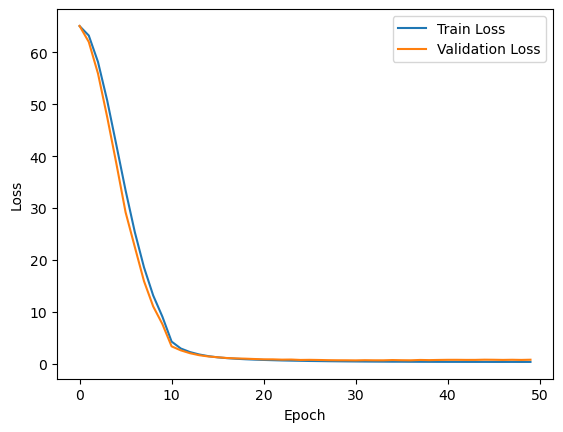

In [29]:
# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Inference

In [30]:
model2=torch.load(weight_path + "task3.pth").to(device)
# Run the testing batches
model2.eval()
with torch.no_grad():
    mse1=0
    nmse1 = 0
    for b,t_x in enumerate(test_loader):
        model2.ar = [None] * 5 
        for time_index,(X, y) in enumerate(t_x):
            y_test_reshaped = CSI_abs_reshape(y.to(device))
            Xin = CSI_abs_reshape(X[0].to(device))
            # Get the input and output for the given time index
            y_pred = model2(Xin, time_index, device, is_training=True, onoffdict = onoffdict)
                
            mse0 = criterion(y_pred, y_test_reshaped) 
            mse1+=mse0  
            
    avg_mse=mse1/(5*num_test_batches)
    

In [31]:
print(f'Average MSE:{avg_mse}')


Average MSE:0.6577075719833374


In [32]:
dict={'train_losses':train_losses, 'val_losses': val_losses, 'test_mse': avg_mse.item() }
savemat(weight_path+'losses.mat', dict)
with open(weight_path+'losses.pkl', 'wb') as file:
    
    # A new file will be created
    pickle.dump(dict, file)

In [33]:
h_list = torch.tensor([])
for b,t_x in enumerate(test_loader):
        for time_index,(X, y) in enumerate(t_x):
            h = CSI_abs_reshape(y)
            h_list = torch.cat([h_list,h])
target_loss = torch.mean((torch.abs(h_list) - torch.mean(torch.abs(h_list))) ** 2)

In [34]:
target_loss

tensor(1.1287)

In [35]:
improvement = (target_loss.item() - avg_mse) / target_loss.item() * 100
print(f'Percentage Improvement Achieved: {improvement:.4f}%')

Percentage Improvement Achieved: 41.7303%
